In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import tensorflow as tf
import variational_autoencoder as vae
import weapon_data as weapons

from tensorflow.python.framework import random_seed

import matplotlib.pyplot as plt
%matplotlib inline

class tfPlugin:
    def __init__(self):
        self._sess = None
        self._vae = None
        self.trained_model_save_folder = "trained_vae/"
        self.training_data_source = "training_data.csv"
        self.test_data_source = "test_data.csv"
        
    def onSetup(self):
        self._random_seed = 19071991
        seed, _ = random_seed.get_seed(self._random_seed)
        np.random.seed(seed)
        
        self.shouldStop = False
        
        self._train_data, self._test_data = weapons.get_data(self.training_data_source, self.test_data_source, seed=self._random_seed)

        #set training parameter
        self._network_architecture = \
            dict(n_input=self._train_data.num_features,
                 n_hidden_1=26,
                 n_hidden_2=12,
                 n_z=2)  
        self._batch_size = 4
        self._learning_rate = 0.01
        self._optimizer = tf.train.RMSPropOptimizer(self._learning_rate)
        self._transfer_fct = tf.nn.elu
        self._num_training_epochs = 100
        
        #keep track of the received and dismantled weapons 
        self._dismantled_weapons = []
        
        #amount of dismantles models needed to retrain the model
        self._dismantled_weapons_needed_to_retrain = 20
        
        #start session is realized in on begin training and will be swaped with the tmp afterwards
        self._sess = None
        self._vae = None
        
        self._trained_model_available = False
        self._trained_model_path = ""
        
    def onJsonInput(self, jsonInput):
        if self._trained_model_available:
            self.__load_trained_model()
            
        if self._vae == None:
            print("ERROR: there is no trained model?!")
            return {}
        
        if not bool(jsonInput):
            print("ERROR: empty input!")
            return {}
        
        generated_weapon = []
        
        #encode the json input to a standardized weapon data
        encoded_json_input = self.__encode_json_input_to_a_standardized_train_data_format(jsonInput)
        #check if the encoded data should be used to generate a new one 
        #calculate loss requires a batch which has the size of the trained model batch_size
        batch = [encoded_json_input[0] for _ in range(self._batch_size)]
        generation_cost = self._vae.calculate_loss(batch)
        generation_cost /= self._batch_size

        #if the cost is too high, then just generate a random one
        #a too high value means that the VAE don't know which weapon that should be!
        if generation_cost >= 50 or np.isnan(generation_cost) or np.isinf(generation_cost):
            generated_weapon = self.__generate_random_weapons(1)
            print("Generated a random weapon!")
        else:
            generated_weapon = self._vae.encode_and_decode(encoded_json_input, False)
            print("Generated a new weapon based on a dismantled one!")

        if len(generated_weapon) <= 0:
            print("ERROR: no generated weapon?!")
            return {}
        
        #do it afterwards so that crazy weapons don't destroy the model
        self.__add_received_dismantled_weapon(encoded_json_input[0])
        
        result, _ = self._train_data.decode_processed_tensor(generated_weapon[0])
        return result
        
    def onBeginTraining(self):
        with tf.Session() as sess:

            #add the dismantled weapons so that the model emerges in a direction
            if len(self._dismantled_weapons) > 0:
                self._train_data.add_new_weapons_and_restandardize_data(self._dismantled_weapons)
                self._dismantled_weapons = []
                self._num_training_epochs += 10

            network = vae.get_untrained(sess, self._network_architecture, self._optimizer, 
                                      self._transfer_fct, self._batch_size)

            num_samples = self._train_data.num_examples
            print("Num of training samples = %i" %num_samples)
            
            #is basically the same code from the VAE file
            #training cycle
            for epoch in range(self._num_training_epochs):
                avg_cost = 0.
                total_batch = int(num_samples / self._batch_size)

                # Loop over all batches
                for _ in range(total_batch):
                    batch = self._train_data.next_batch(self._batch_size)

                    # Fit training using batch data
                    cost = network.train_with_mini_batch(batch)

                    #compute average loss/cost
                    avg_cost += cost / num_samples * self._batch_size

                # Display logs per epoch step
                if (epoch+1) % 10 == 0:
                    print("Epoch:"+ '%04d' % (epoch+1) + " - Cost:" + "{:.2f}".format(avg_cost))

                if self.shouldStop:
                    break;

            self._trained_model_path = network.save_trained_model(self.trained_model_save_folder)
            self._trained_model_available = True
        
        
    def onStopTraining(self):
        if self._sess:
            self._sess.close()
        
    def __load_trained_model(self):
        if self._sess:
            self._sess.close()
        tf.reset_default_graph()
    
        self._sess = tf.Session(graph=tf.get_default_graph())
        self._vae = vae.get_untrained(self._sess, self._network_architecture, self._optimizer, 
                                  self._transfer_fct, self._batch_size)
        self._vae = vae.restore(self._vae, self._trained_model_path)
        self._trained_model_available = False
        
    def __encode_json_input_to_a_standardized_train_data_format(self, json_input):
        prepared_for_encoding = self._train_data.prepare_decoded_tensor_dict_for_encoding(json_input)
        encoded, _ = self._train_data.encode_features_dict(prepared_for_encoding)
        encoded_standardized = self._train_data.standardize_encoded_data(encoded[0])
        return [encoded_standardized]
    
    def __add_received_dismantled_weapon(self, weapon):
        self._dismantled_weapons.append(weapon)
        
        if len(self._dismantled_weapons) >= self._dismantled_weapons_needed_to_retrain:
            self.shouldRetrain = True
            print("Should retrain!")
    
    def __generate_random_weapons(self, num):
        generated_weapons = []
        
        for _ in range(num):
            random_val = np.random.normal(size=(1, self._network_architecture["n_z"]))
            weapons = self._vae.decode_from_latent_space(random_val, False)
            [generated_weapons.append(weapon) for weapon in weapons]
            
        return generated_weapons
    
    def __print_decoded_tensors_as_dict(self, array_of_tensors):
        genDict = {}

        for tensor in array_of_tensors:
            decoded, _ = weapon_data.decode_processed_tensor(tensor)

            for key, value in decoded.items():
                if key not in genDict:
                    genDict[key] = []
                genDict[key].append(value)

        for key, value in genDict.items():
                print(key, "=", value)
                
    def show_z_distribution(self, title, z_mean=True):
        all_z = np.zeros((self._batch_size,self._network_architecture['n_z']))

        total_batch = int(self._train_data.num_examples / self._batch_size) 

        # Loop over all batches
        for i in range(total_batch):
            batch = self._train_data.next_batch(self._batch_size)
            z_dist = self._vae.calculate_z(batch)
            if z_mean:
                z_dist = self._vae.calculate_z_mean(batch)
            all_z = np.vstack((all_z, z_dist))

        plt.figure(figsize=(15,5))
        plt.subplot(1,2,1)
        plt.scatter(all_z[:,0], all_z[:,1])
        plt.xlim(-3,3)
        plt.ylim(-3,3)
        plt.title(title)
        plt.subplot(1,2,2)
        plt.hist2d(all_z[:,0], all_z[:,1], (50, 50), cmap=plt.cm.jet)
        plt.colorbar()
        plt.title(title)


D:\z_outsourced_programs\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Num of training samples = 127
Epoch:0010 - Cost:12.00
Epoch:0020 - Cost:11.29
Epoch:0030 - Cost:9.96
Epoch:0040 - Cost:9.76
Epoch:0050 - Cost:9.60
Epoch:0060 - Cost:9.64
Epoch:0070 - Cost:8.98
Epoch:0080 - Cost:9.39
Epoch:0090 - Cost:8.34
Epoch:0100 - Cost:8.88
INFO:tensorflow:Restoring parameters from trained_vae/model.ckpt
ERROR: empty input!


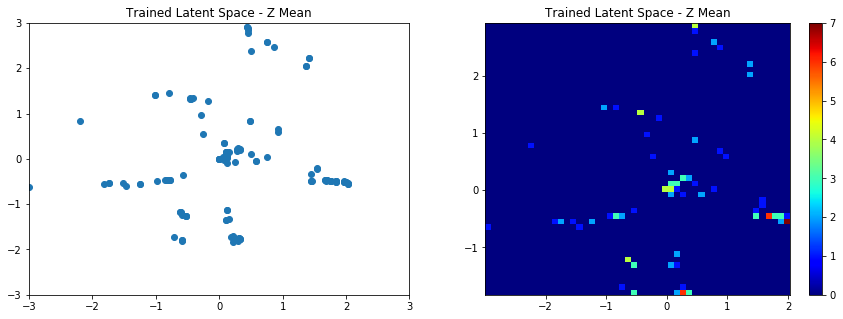

In [2]:
pluginTest = tfPlugin()
pluginTest.onSetup()
pluginTest.onBeginTraining()
pluginTest.onJsonInput({})
pluginTest.show_z_distribution("Trained Latent Space - Z Mean", z_mean=True)

In [3]:
json_test = {'damages_first': '26.5',
 'damages_last': '6.25',
 'distances_first': '14.0',
 'distances_last': '21.0',
 'firemode_Automatic': '0.0',
 'firemode_Semi-Automatic': '0.0',
 'firemode_Single-Action': '1.0',
 'hiprecoildec': '6.0',
 'hiprecoilright': '1.2000000476837158',
 'hiprecoilup': '11.0',
 'hipstandbasespreaddec': '4.5',
 'hipstandbasespreadinc': '0.30000001192092896',
 'hordispersion': '2.700000047683716',
 'initialspeed': '333.0',
 'magsize': '2.0',
 'reloadempty': '5.333333492279053',
 'rof': '299.0',
 'shotspershell': '12.0',
 'type_Pistol': '0.0',
 'type_Rifle': '-2.7755575615628914e-17',
 'type_Shotgun': '1.0',
 'type_Sniper Rifle': '0.0',
 'type_Submachine Gun': '0.0',
 'type_Light Machine Gun' : '0.0'}

def input_and_train():
    global pluginTest, json_test
    for _ in range(pluginTest._dismantled_weapons_needed_to_retrain):
        for key, value in json_test.items():
            if "type" not in key or "firemode" not in key:
                new_value = float(value) * np.random.uniform(low=0.8, high=5.2)
                json_test[key] = str(new_value)
        print(pluginTest.onJsonInput(json_test))
    pluginTest.onBeginTraining()
    pluginTest.show_z_distribution("Trained Latent Space - Z Mean", z_mean=True)

Generated a random weapon!
{'damages_first': '55.863542216232545', 'damages_last': '43.000452886384075', 'distances_first': '21.464647524506294', 'distances_last': '81.96909341364375', 'firemode_Automatic': '0.5488721677975144', 'firemode_Semi': '0.5842115582335115', 'firemode_Single': '0.46565735128019614', 'hiprecoildec': '6.649562803129771', 'hiprecoilright': '0.7597350199009365', 'hiprecoilup': '3.8771670156812146', 'hipstandbasespreaddec': '9.156408745558332', 'hipstandbasespreadinc': '0.5266789538031101', 'initialspeed': '666.863442948676', 'magsize': '38.773934892121986', 'reloadempty': '4.345553903482978', 'rof': '414.31630290180124', 'shotspershell': '2.9877617232745513', 'type_Shotgun': '0.21891611734096894', 'type_Pistol': '0.3763672480337807', 'type_Rifle': '0.40690900042432554', 'type_SMG': '0.2553983594597427', 'type_Sniper': '0.40690900042432554', 'type_MG': '0.26714040308742415'}
Generated a random weapon!
{'damages_first': '32.17719782558311', 'damages_last': '20.02069

Generated a random weapon!
{'damages_first': '73.50988183121304', 'damages_last': '60.12038536964154', 'distances_first': '31.53759499670715', 'distances_last': '111.56684700089967', 'firemode_Automatic': '0.8807692957400506', 'firemode_Semi': '0.9224105232322005', 'firemode_Single': '0.7773065723006178', 'hiprecoildec': '8.624676371047727', 'hiprecoilright': '1.0357097017729555', 'hiprecoilup': '5.8180052004459935', 'hipstandbasespreaddec': '12.720638522543702', 'hipstandbasespreadinc': '0.8004055839391847', 'initialspeed': '811.3318371864424', 'magsize': '63.721508203284074', 'reloadempty': '5.2123175606891134', 'rof': '571.0050217704596', 'shotspershell': '4.9559713475752325', 'type_Shotgun': '0.4229384238552696', 'type_Pistol': '0.657807020318306', 'type_Rifle': '0.6996948926911829', 'type_SMG': '0.4805073034760957', 'type_Sniper': '0.699694892691183', 'type_MG': '0.4985916850341767'}
Generated a random weapon!
{'damages_first': '81.24268928832709', 'damages_last': '67.622515809171

Generated a random weapon!
Should retrain!
{'damages_first': '34.25683420172912', 'damages_last': '22.038293568100677', 'distances_first': '9.131028222942426', 'distances_last': '45.728715318338274', 'firemode_Automatic': '0.14248735991255054', 'firemode_Semi': '0.17011059185913047', 'firemode_Single': '0.08406468852654184', 'hiprecoildec': '4.231174452422821', 'hiprecoilright': '0.42182333392487686', 'hiprecoilup': '1.5007464731449314', 'hipstandbasespreaddec': '4.792258798985589', 'hipstandbasespreadinc': '0.1915198498650167', 'initialspeed': '489.97200371956427', 'magsize': '8.227377137612057', 'reloadempty': '3.284262459055747', 'rof': '222.46193130806603', 'shotspershell': '0.5778267684072917', 'type_Shotgun': '-0.03089492004594191', 'type_Pistol': '0.03176394128013821', 'type_Rifle': '0.04841316372369872', 'type_SMG': '-0.020231789961470084', 'type_Sniper': '0.04841316372369864', 'type_MG': '-0.0162554953095774'}
Num of training samples = 147
Epoch:0010 - Cost:11.90
Epoch:0020 - 

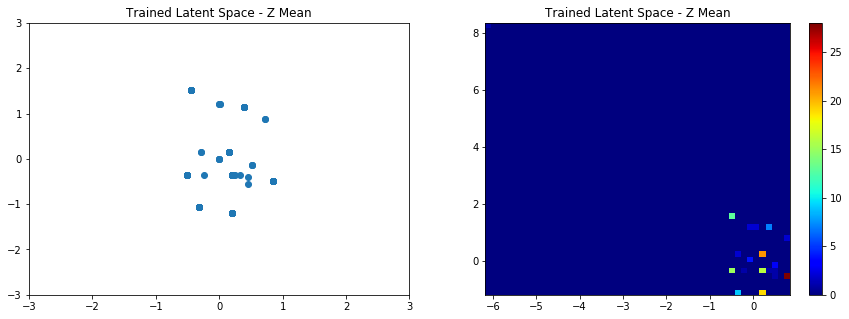

In [4]:
input_and_train()

In [5]:
input_and_train()

INFO:tensorflow:Restoring parameters from trained_vae/model.ckpt
Generated a random weapon!
{'damages_first': '36206512.63499995', 'damages_last': '133768345.09826192', 'distances_first': '1798974865.587079', 'distances_last': '24950522.48968268', 'firemode_Automatic': '0.4422830750458693', 'firemode_Semi': '0.472922824224248', 'firemode_Single': '0.3710557842978644', 'hiprecoildec': '650095978.57587', 'hiprecoilright': '60726383.08611872', 'hiprecoilup': '288272400.4961808', 'hipstandbasespreaddec': '10436387.36585838', 'hipstandbasespreadinc': '84879.097610143', 'initialspeed': '30596413307.46126', 'magsize': '246259754.4483463', 'reloadempty': '13719746.104418367', 'rof': '67753246.82268366', 'shotspershell': '426681873.6494102', 'type_Shotgun': '0.16710728990576995', 'type_Pistol': '0.2959837354541713', 'type_Rifle': '0.32150698772008734', 'type_SMG': '0.19653658282827888', 'type_Sniper': '0.32150698772008734', 'type_MG': '0.20606796528712018'}
Generated a random weapon!
{'damages_

Generated a random weapon!
{'damages_first': '36715926.13706058', 'damages_last': '135803728.56908602', 'distances_first': '1825232139.7011797', 'distances_last': '25316999.299529582', 'firemode_Automatic': '0.445238062791968', 'firemode_Semi': '0.47594868505594157', 'firemode_Single': '0.3738040186709598', 'hiprecoildec': '659636084.3764353', 'hiprecoilright': '61639047.50437254', 'hiprecoilup': '292632461.4697554', 'hipstandbasespreaddec': '10594517.681747407', 'hipstandbasespreadinc': '86087.54113117071', 'initialspeed': '31045861489.383293', 'magsize': '250004411.1881612', 'reloadempty': '13913250.727682628', 'rof': '68723904.8217223', 'shotspershell': '433085781.0704365', 'type_Shotgun': '0.1688740120027598', 'type_Pistol': '0.2984457470427982', 'type_Rifle': '0.3240747258856155', 'type_SMG': '0.19848976759646064', 'type_Sniper': '0.3240747258856155', 'type_MG': '0.20807755025208857'}
Generated a random weapon!
{'damages_first': '37242341.264754616', 'damages_last': '137907042.763

KeyboardInterrupt: 

In [ ]:
input_and_train()

In [ ]:
input_and_train()

In [ ]:
input_and_train()

In [ ]:
input_and_train()

In [ ]:
input_and_train()

In [ ]:
input_and_train()

In [ ]:
input_and_train()

In [ ]:
input_and_train()

In [ ]:
pluginTest.onJsonInput(json_test)